# Running Track Discriminator

There is only one running track. Thus, it is easy to augment train data. In fact, if a model is only trained on the groudtruth, it is kind of insufficient, even after optimizations of hyperparameters. It generates noise in addition to the running track.

The goal of this section is to fully discriminate the running track and minimize the noise.

In [2]:
import numpy as np
from utils import data_get, Classes, save, load, cmap_get

In [3]:
X, y = data_get()

In [4]:
hsi = np.load("data/hyperspectral.npy")
lidar = np.load("data/lidar.npy")

### Data Augmentation

After the 500 column, there is no more running track.

In [31]:
hsi0 = hsi[::2, :500:2].reshape(-1, hsi.shape[-1])
hsi1 = hsi[::2, 750::2].reshape(-1, hsi.shape[-1])
lidar0 = lidar[::2, :500:2].reshape(-1)
lidar1 = lidar[::2, 750::2].reshape(-1)
hsi_bis = np.vstack((hsi0, hsi1))
lidar_bis = np.hstack((lidar0, lidar1))
bis = np.hstack((hsi_bis, lidar_bis.reshape((-1, 1))))
bis.shape

(144900, 145)

In [32]:
X_bis = np.vstack((X, bis))
y_bis = y.copy()
y_bis[y_bis != Classes.TENNIS_COURT] = 0
y_bis = np.hstack((y_bis, np.zeros(lidar_bis.shape)))
X_bis.shape, y_bis.shape

((147732, 145), (147732,))

### Descriminator

In [33]:
from discriminator_classifier import DiscriminatorClassifier
from sklearn.svm import LinearSVC

In [34]:
model = DiscriminatorClassifier._Discriminator(
    X_bis,
    y_bis,
    [Classes.TENNIS_COURT],
    LinearSVC(
        C=10,
        random_state=42,
        max_iter=2000,
        dual="auto",
    ),
)

In [35]:
model.fit()

/home/ucin/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, dual='auto', max_iter=2000, random_state=42))])

In [36]:
model.score()

0.9997292449318036

In [39]:
model.optimize(
    dict(),
    dict(
        C=(1, 100, 200, 300),
    ),
    n_jobs=16,
)

KeyboardInterrupt: 

In [38]:
model.score()

0.9997292449318036

In [44]:
save(model, "running_track_discriminator")

Trying to optimize would not result in a better accuracy score

### Visualize

In [14]:
from matplotlib import pyplot as plt

In [15]:
hsi_reshaped = hsi.reshape(-1, hsi.shape[-1])
lidar_reshaped = lidar.reshape(-1)
hsi_reshaped.shape, lidar_reshaped.shape

((664845, 144), (664845,))

In [16]:
img_features = np.hstack((hsi_reshaped, lidar_reshaped.reshape(-1, 1)))
img_features.shape

(664845, 145)

In [17]:
y_pred = model.predict(img_features)

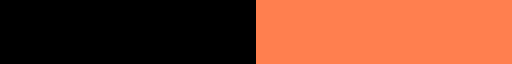

In [18]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(np.array([[[0.0, 0.0, 0.0]], [[1.0, 0.49803922, 0.31372549]]]))
cmap

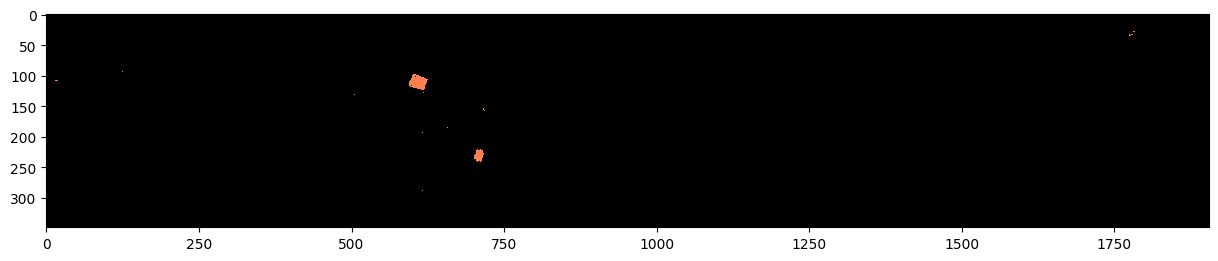

In [19]:
img_pred = y_pred.reshape(lidar.shape)
plt.figure(figsize=(15, 15))
plt.imshow(img_pred, cmap=cmap)

### Postprocessing

In [20]:
from skimage.morphology import closing, opening, square

In [27]:
img_pred_bis = opening(closing(img_pred, square(3)))

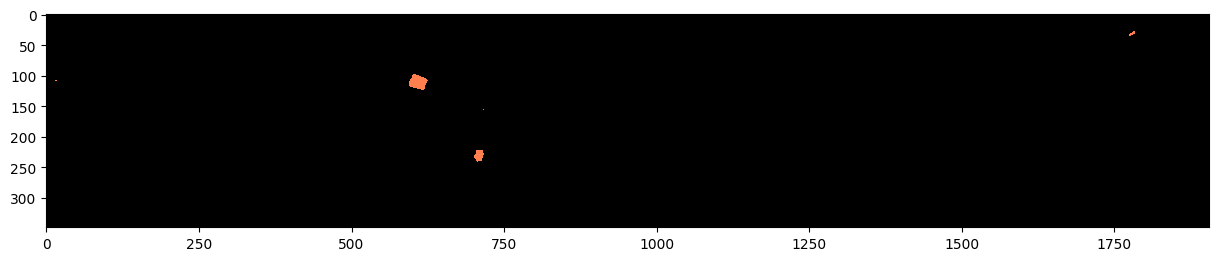

In [28]:
plt.figure(figsize=(15, 15))
plt.imshow(img_pred_bis, cmap=cmap)

### Solution

In [60]:
from utils import load
from skimage.morphology import closing, opening, square


def running_track_discriminate(hsi, lidar):
    hsi_reshaped = hsi.reshape(-1, hsi.shape[-1])
    lidar_reshaped = lidar.reshape(-1, 1)
    img_features = np.hstack((hsi_reshaped, lidar_reshaped))
    model = load("running_track_discriminator")
    y_pred = model.predict(img_features)
    img_pred = y_pred.reshape(hsi.shape[:-1])
    img_pred = closing(img_pred, square(3))
    img_pred = opening(img_pred)
    return img_pred

In [61]:
img_pred = running_track_discriminate(hsi, lidar)

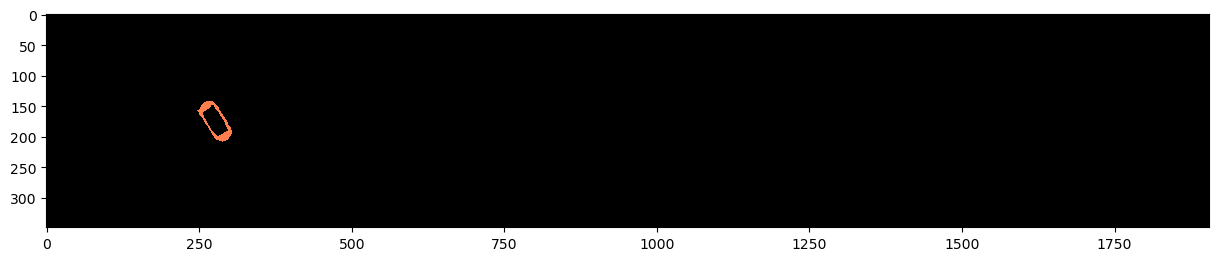

In [62]:
plt.figure(figsize=(15, 15))
plt.imshow(img_pred, cmap=cmap)